In [1]:
%matplotlib inline
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [35]:
def Image_Data(dir_path, MPN = 1):
    image_list = os.listdir(dir_path)
    image_list.sort()
    
    list_len = len(image_list)
    print("이미지 파일 총 갯수 : ",list_len)
    
    image1 = []
    image2 = []
    CoN = [] # correct[0 1] or not[0 1]
    
    #--- 묶음 제작
    
    pick_num = 10 # 뽑을 묶음 수
    saved_name = image_list[0][:4] # ID가 이름의 4번째까지 이므로
    front = 0
    back = 0
    
    for index, img_name in enumerate(image_list):
        if img_name[:4] == saved_name and index+1 != list_len:
            continue
        saved_name = img_name[:4]
        back = index
        if back-front == 1:
            front = index
            continue
        for i in range(pick_num):
            D1,D2 = random.sample(range(front,back),2)
            image1.append(D1)
            image2.append(D2)
            CoN.append([0,1])
        for i in range(pick_num*MPN):
            D1 = random.sample(range(front,back),1)
            while(True):
                D2 = random.sample(range(0,list_len),1)
                if front>D2[0] or D2[0]>back: break
            image1.extend(D1)
            image2.extend(D2)
            CoN.append([1,0])
        front = index
        
    CoN=np.asarray(CoN)
    
    nsp, sp = np.sum(CoN,axis=0)
    print("Total : ",len(CoN))
    print("같은사람 : ",sp)
    print("다른사람 : ",nsp)
    
    return image_list, image1, image2, CoN

### For Testing ###
# testing_number 만큼의 사람들을 그 만큼 모두 짝지어 리턴해줍니다.

def ALL_Image_Data(dir_path, testing_number = 100):
    image_list = os.listdir(dir_path)
    image_list.sort()
    
    list_len = len(image_list)
    print("이미지 파일 총 갯수 : ",list_len)
    print("뽑을 사람 : ",testing_number)
    
    image1 = []
    image2 = []
    CoN = [] # correct[0 1] or not[0 1]
    
    
    ### testing_number 만큼의 사람이 어디까진지 파악하는 코드 ###
    saved_name = image_list[0][:4] # ID가 이름의 4번째까지 이므로
    number_of_people = 1
    
    for index, img_name in enumerate(image_list):
        if testing_number+1 == number_of_people: break
        if img_name[:4] == saved_name:
            continue
        saved_name = img_name[:4]
        number_of_people += 1
    list_len = index-1
    print(testing_number,"명 만큼의 사람의 사진은",list_len,"장 입니다.")
    ### -------------------------------------------------- ###
    
    saved_name = image_list[0][:4]
    front = 0
    back = 0
    
    for index, img_name in enumerate(image_list[:list_len]):
        
        if img_name[:4] == saved_name and index+1 != list_len:
            continue
        if index+1 == list_len: index = list_len
            
        saved_name = img_name[:4]
        back = index
        
        if back-front == 1:
            front = index
            continue
        
        image1.extend([front] * (list_len-1))
        image2.extend(list(range(0,front))+list(range(front+1,list_len)))
        for i in range(front):CoN.append([1,0])
        for i in range(back-front-1): CoN.append([0,1])
        for i in range(list_len-back): CoN.append([1,0])
        
        front = index
    
    CoN=np.asarray(CoN)
    return image_list, image1, image2, CoN

def CrossND (input1, input2, stride = 3):
    # padding stride 미적용 일단 3으로 할 것
    L = len(input1.shape)
    if L==2: print("3차원 이상만 가능합니다.")
    elif L==3: paddings = tf.constant([[0, 0], [1, 1], [1, 1]])
    elif L==4: paddings = tf.constant([[0, 0], [0, 0], [1, 1], [1, 1]])
    else: print("미구현됨...")
        
    input2 = tf.pad(input2, paddings, "CONSTANT")
    for i in range(input1.shape[L-2]):
        if L==3: F1 = tf.subtract(tf.reshape(input1[:,i,0],[input1.shape[L-3],1,1]),input2[:,i:i+stride,:stride])
        elif L==4: F1 = tf.subtract(tf.reshape(input1[:,:,i,0],[-1,input1.shape[L-3],1,1]),input2[:,:,i:i+stride,:stride])
        F1 = tf.abs(F1)
        for j in range(input1.shape[L-1]):
            if j == 0: continue
            if L==3: F2 = tf.subtract(tf.reshape(input1[:,i,j],[input1.shape[L-3],1,1]),input2[:,i:i+stride,j:j+stride])
            elif L==4: F2 = tf.subtract(tf.reshape(input1[:,:,i,j],[-1,input1.shape[L-3],1,1]),input2[:,:,i:i+stride,j:j+stride])
            F2 = tf.abs(F2)
            F1 = tf.concat([F1,F2],L-1)
        if i==0:
            output = F1
            continue
        output = tf.concat([output,F1],L-2)
    return output

def ConvNet(x, in_channels, filter_count, batch_prob, stride = 1,filter_size = 3, mu = 0.5, sigma = 0.01):
    # W = tf.Variable(tf.random_normal([filter_size,filter_size,in_channels,filter_count], stddev = sigma))
    # b = tf.Variable(tf.random_normal([1,1,filter_count], mean = mu, stddev = sigma))
    W = tf.get_variable("W",[filter_size,filter_size,in_channels,filter_count],initializer=tf.random_normal_initializer(0, sigma))
    #print(W)
    b = tf.get_variable("b",[1,1,filter_count],initializer=tf.random_normal_initializer(mu, sigma))
    x = tf.nn.conv2d(x,W,strides=[1,stride,stride,1],padding='SAME')
    x = tf.add(x,b)
    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob, name = "batch_norm")
    return tf.nn.relu(x)

def inception2d_v2(x, in_channels, filter_count, batch_prob, mu=0, sigma=0.01):
    
    # 1x1
    one_filter_1 = tf.get_variable("one_filter_1",[1, 1, in_channels, filter_count[0]],initializer=tf.initializers.truncated_normal(mu,sigma))
    one_by_one = tf.nn.conv2d(x, one_filter_1, strides=[1, 1, 1, 1], padding='SAME')
    one_by_one = tf.layers.batch_normalization(one_by_one, center=True, scale=True, training=batch_prob, name = "batch_norm1")
    
    # 3x3
    one_filter_3 = tf.get_variable("one_filter_3",[1, 1, in_channels, int(filter_count[1]*(2/3))],initializer=tf.initializers.truncated_normal(mu,sigma))
    three_filter = tf.get_variable("three_filter",[3, 3, int(filter_count[1]*(2/3)), filter_count[1]],initializer=tf.initializers.truncated_normal(mu,sigma))
    three_by_three = tf.nn.conv2d(x, one_filter_3, strides=[1, 1, 1, 1], padding='SAME')
    three_by_three = tf.nn.conv2d(three_by_three, three_filter, strides=[1, 1, 1, 1], padding='SAME')
    three_by_three = tf.layers.batch_normalization(three_by_three, center=True, scale=True, training=batch_prob, name = "batch_norm2")
    
    # 5x5
    one_filter_5 = tf.get_variable("one_filter_5",[1, 1, in_channels, int(filter_count[2]/2)],initializer=tf.initializers.truncated_normal(mu,sigma))
    five_filter = tf.get_variable("five_filter",[5, 5, int(filter_count[2]/2), filter_count[2]],initializer=tf.initializers.truncated_normal(mu,sigma))
    five_by_five = tf.nn.conv2d(x, one_filter_5, strides=[1, 1, 1, 1], padding='SAME')
    five_by_five = tf.nn.conv2d(five_by_five, five_filter, strides=[1, 1, 1, 1], padding='SAME')
    five_by_five = tf.layers.batch_normalization(five_by_five, center=True, scale=True, training=batch_prob, name = "batch_norm3")
    
    # avg pooling
    one_filter_p = tf.get_variable("one_filter_p",[1, 1, in_channels, filter_count[3]],initializer=tf.initializers.truncated_normal(mu,sigma))
    pooling = tf.nn.avg_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    pooling_by_one = tf.nn.conv2d(pooling, one_filter_p, strides=[1, 1, 1, 1], padding='SAME')
    
    x = tf.concat([one_by_one, three_by_three, five_by_five, pooling_by_one], axis=3)  # Concat in the 4th dim to stack
    
    return tf.nn.relu(x)

def PCB(x, stripes):
    M = x.shape[1]
    N = x.shape[2]
    T = x.shape[3]
    
    W = tf.get_variable("PCB_W",[1,1,T,stripes],initializer=tf.random_normal_initializer)
    
    Pi_f = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    Pi_f = tf.nn.softmax(Pi_f)
    
    new_x = x * tf.reshape(Pi_f[:,:,:,0],[-1,M,N,1])
    for i in range(1,stripes):
        new_x = tf.concat([new_x, x * tf.reshape(Pi_f[:,:,:,i],[-1,M,N,1])], axis=3)
    
    return new_x

def PCB_v2(x, stripes, RPP = True):
    M = x.shape[1]
    N = x.shape[2]
    T = x.shape[3]
    
    if RPP:
        W = tf.get_variable("PCB_W",[1,1,T,stripes],initializer=tf.random_normal_initializer)
    
        Pi_f = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        Pi_f = tf.nn.softmax(Pi_f)
    
        new_x = x * tf.reshape(Pi_f[:,:,:,0],[-1,M,N,1])
        for i in range(1,stripes):
            new_x = tf.concat([new_x, x * tf.reshape(Pi_f[:,:,:,i],[-1,M,N,1])], axis=3)
        new_x = tf.nn.relu(new_x)
    else:
        s = int(int(M)/stripes)
        new_x = x[:,:s,:,:]
        for i in range(1,stripes):
            new_x = tf.concat([new_x,x[:,i*s:(i+1)*s,:,:]], axis=3)
    
    return new_x

def PCB_v3(x, stripes, batch_prob,RPP = True):
    M = x.shape[1]
    N = x.shape[2]
    T = x.shape[3]
    
    s = int(int(M)/stripes)
    
    if RPP:
        W = tf.get_variable("PCB_W",[1,1,T,stripes],initializer=tf.random_normal_initializer)
    
        Pi_f = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        Pi_f = tf.layers.batch_normalization(Pi_f, center=True, scale=True, training=batch_prob, name = "batch_norm_1")
        Pi_f = tf.nn.softmax(Pi_f)
    
        new_x = x[:,:s,:,:] * tf.reshape(Pi_f[:,:s,:,0],[-1,s,N,1])
        for i in range(1,stripes):
            new_x = tf.concat([new_x, x[:,i*s:(i+1)*s,:,:] * tf.reshape(Pi_f[:,i*s:(i+1)*s,:,i],[-1,s,N,1])], axis=3)
        
        new_x = tf.layers.batch_normalization(new_x, center=True, scale=True, training=batch_prob, name = "batch_norm_2")
        new_x = tf.nn.relu(new_x)
    else:
        new_x = x[:,:s,:,:]
        for i in range(1,stripes):
            new_x = tf.concat([new_x,x[:,i*s:(i+1)*s,:,:]], axis=3)
    
    return new_x

def PCB_v4(x, stripes, batch_prob,RPP = True):
    M = x.shape[1]
    N = x.shape[2]
    T = x.shape[3]
    
    s = int(int(M)/stripes)
    
    if RPP:
        W = tf.get_variable("PCB_W",[1,1,T,stripes],initializer=tf.random_normal_initializer)
    
        Pi_f = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        Pi_f = tf.layers.batch_normalization(Pi_f, center=True, scale=True, training=batch_prob, name = "batch_norm_1")
        Pi_f = tf.nn.softmax(Pi_f)
    
        new_x = x[:,:s,:,:] * tf.reshape(Pi_f[:,:s,:,0],[-1,s,N,1])
        for i in range(1,stripes):
            new_x = tf.concat([new_x, x[:,i*s:(i+1)*s,:,:] * tf.reshape(Pi_f[:,i*s:(i+1)*s,:,i],[-1,s,N,1])], axis=1)
        
        new_x = tf.layers.batch_normalization(new_x, center=True, scale=True, training=batch_prob, name = "batch_norm_2")
        new_x = tf.nn.relu(new_x)
    else:
        new_x = x[:,:s,:,:]
        for i in range(1,stripes):
            new_x = tf.concat([new_x,x[:,i*s:(i+1)*s,:,:]], axis=3)
    
    return new_x

def Seperator(x, stripes):
    M = int(x.shape[1])
    T = int(x.shape[3])
    Part = []
    
    for i in range(stripes):
        s = int(T/stripes)
        chunk = x[:,:,:,i*s:(i+1)*s]
        chunk = tf.reduce_mean(chunk, axis = 2)#, keepdims=True)
        chunk = tf.reduce_mean(chunk, axis = 1)#, keepdims=True)
        Part.append(chunk)
            
    return Part

def Seperator_v2(x, stripes):
    M = int(x.shape[1])
    T = int(x.shape[3])
    
    for i in range(stripes):
        s = int(T/stripes)
        chunk = x[:,:,:,i*s:(i+1)*s]
        chunk = tf.reduce_mean(chunk, axis = 2)#, keepdims=True)
        chunk = tf.reduce_mean(chunk, axis = 1)#, keepdims=True)
        #chunk = tf.reduce_mean(chunk, axis = 1, keepdims=True)
        if i == 0:
            Part = chunk
        else:
            Part = tf.concat([Part, chunk], axis = 1)
    
    return Part

def Seperator_v3(x, stripes):
    M = int(x.shape[1])
    
    for i in range(stripes):
        s = int(M/stripes)
        chunk = x[:,i*s:(i+1)*s,:,:]
        chunk = tf.reduce_mean(chunk, axis = 2)#, keepdims=True)
        chunk = tf.reduce_mean(chunk, axis = 1)#, keepdims=True)
        #chunk = tf.reduce_mean(chunk, axis = 1, keepdims=True)
        if i == 0:
            Part = chunk
        else:
            Part = tf.concat([Part, chunk], axis = 1)
    
    return Part

def FC_layer(x, input_size, batch_prob, output_size = 2):
    W1 = tf.Variable(tf.random_normal([input_size,4096], stddev = 0.2))
    W2 = tf.Variable(tf.random_normal([4096,4096], stddev = 0.2))
    W3 = tf.Variable(tf.random_normal([4096,512], stddev = 0.2))
    W4 = tf.Variable(tf.random_normal([512,output_size], stddev = 0.2))

    b1 = tf.Variable(tf.random_normal([4096], mean = 0.5, stddev = 0.01))
    b2 = tf.Variable(tf.random_normal([4096], mean = 0.5, stddev = 0.01))
    b3 = tf.Variable(tf.random_normal([512], mean = 0.5, stddev = 0.01))
    b4 = tf.Variable(tf.random_normal([output_size], mean = 0.5, stddev = 0.01))
    
    x = tf.reshape(x, [-1,input_size])
    x = tf.add(tf.matmul(x,W1),b1)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob)
    x = tf.nn.sigmoid(x)
    print(x)

    x = tf.add(tf.matmul(x,W2),b2)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob)
    x = tf.nn.sigmoid(x)
    print(x)

    x = tf.add(tf.matmul(x,W3),b3)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob)
    x = tf.nn.sigmoid(x)
    print(x)

    x = tf.add(tf.matmul(x,W4),b4)
    print(x)
    return x


def FC_layer_v2(x, in_channels, batch_prob, output_size = 2):
    # W1 = tf.Variable(tf.random_normal([in_channels,512], stddev = 0.2))
    W1 = tf.get_variable("W1",[in_channels,512],initializer=tf.random_normal_initializer(0,0.2))
    # W2 = tf.Variable(tf.random_normal([512,512], stddev = 0.2))
    W2 = tf.get_variable("W2",[512,512],initializer=tf.random_normal_initializer(0,0.2))
    # W3 = tf.Variable(tf.random_normal([512,output_size], stddev = 0.2))
    W3 = tf.get_variable("W3",[512,output_size],initializer=tf.random_normal_initializer(0,0.2))

    # b1 = tf.Variable(tf.random_normal([512], mean = 0.5, stddev = 0.01))
    b1 = tf.get_variable("b1",[512],initializer=tf.random_normal_initializer(0.5,0.01))
    #b2 = tf.Variable(tf.random_normal([512], mean = 0.5, stddev = 0.01))
    b2 = tf.get_variable("b2",[512],initializer=tf.random_normal_initializer(0.5,0.01))
    #b3 = tf.Variable(tf.random_normal([output_size], mean = 0.5, stddev = 0.01))
    b3 = tf.get_variable("b3",[output_size],initializer=tf.random_normal_initializer(0.5,0.01))
    
    x = tf.reshape(x, [-1,in_channels])
    x = tf.add(tf.matmul(x,W1),b1)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob)
    x = tf.nn.sigmoid(x)
    #print(x)

    x = tf.add(tf.matmul(x,W2),b2)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob)
    x = tf.nn.sigmoid(x)
    #print(x)

    x = tf.add(tf.matmul(x,W3),b3)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob)
    #print(x)

    return x

def FC_layer_v3(x, in_channels, batch_prob, output_size = 2):
    W1 = tf.get_variable("W",[in_channels,output_size],initializer=tf.random_normal_initializer(0,0.2))
    b1 = tf.get_variable("b",[output_size],initializer=tf.random_normal_initializer(0.5,0.01))
    
    x = tf.reshape(x, [-1,in_channels])
    x = tf.add(tf.matmul(x,W1),b1)

    x = tf.layers.batch_normalization(x, center=True, scale=True, training=batch_prob, name="FC_batch_norm")
    return x

def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))

이미지 파일 총 갯수 :  14097
Total :  88020
같은사람 :  14670
다른사람 :  73350
first pic =  0000_06.jpg
second pic =  0000_00.jpg
answer is =  [0 1]


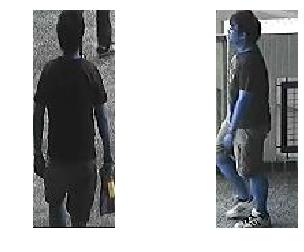

first pic =  0000_03.jpg
second pic =  0000_07.jpg
answer is =  [0 1]


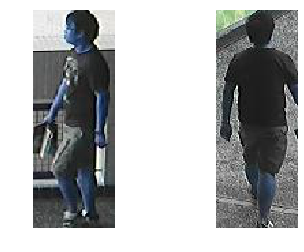

first pic =  0000_04.jpg
second pic =  0000_05.jpg
answer is =  [0 1]


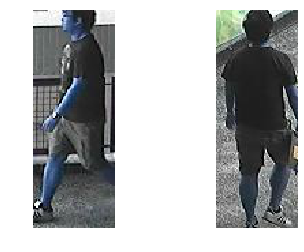

first pic =  0000_05.jpg
second pic =  0000_00.jpg
answer is =  [0 1]


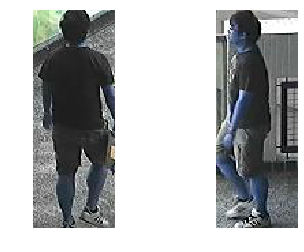

first pic =  0000_00.jpg
second pic =  0000_05.jpg
answer is =  [0 1]


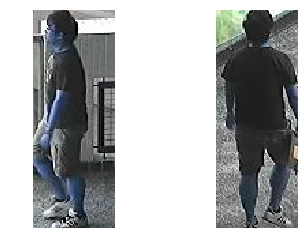

first pic =  0000_02.jpg
second pic =  0000_07.jpg
answer is =  [0 1]


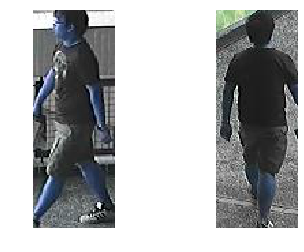

first pic =  0000_07.jpg
second pic =  0000_02.jpg
answer is =  [0 1]


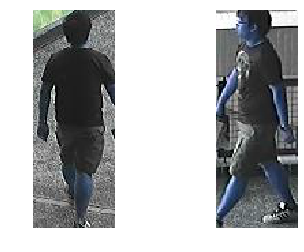

first pic =  0000_08.jpg
second pic =  0000_09.jpg
answer is =  [0 1]


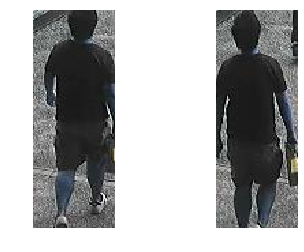

first pic =  0000_01.jpg
second pic =  0000_07.jpg
answer is =  [0 1]


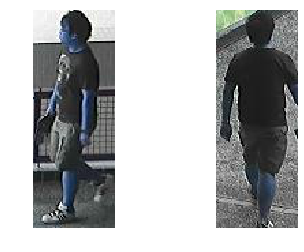

first pic =  0000_00.jpg
second pic =  0000_01.jpg
answer is =  [0 1]


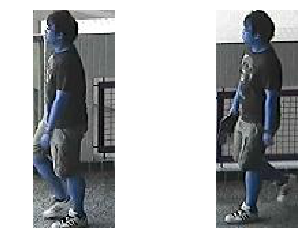

In [3]:
train_dir = '/home/esdl/tensorflow/cuhk03_release/images/detected'
train_list, train_data1, train_data2, train_CoN = Image_Data(train_dir,5)

data_index = list(range(len(train_data1)))

for i in data_index[:10]:
    img1 = cv2.imread(train_dir+'/'+train_list[train_data1[i]],cv2.IMREAD_COLOR)
    img2 = cv2.imread(train_dir+'/'+train_list[train_data2[i]],cv2.IMREAD_COLOR)
    fig , ax = plt.subplots(1, 2)
    ax[0].set_axis_off()
    ax[1].set_axis_off()

    ax[0].imshow(img1)
    ax[1].imshow(img2)
    
    print("first pic = ",train_list[train_data1[i]])
    print("second pic = ",train_list[train_data2[i]])
    print("answer is = ",train_CoN[i])
    plt.show()
    plt.close(fig)

이미지 파일 총 갯수 :  3884
Total :  19420
같은사람 :  9710
다른사람 :  9710
first pic =  0084002.png
second pic =  0084004.png
answer is =  [0 1]


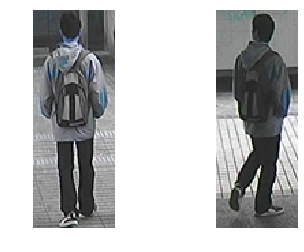

first pic =  0705004.png
second pic =  0705002.png
answer is =  [0 1]


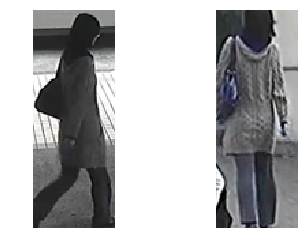

first pic =  0275004.png
second pic =  0275003.png
answer is =  [0 1]


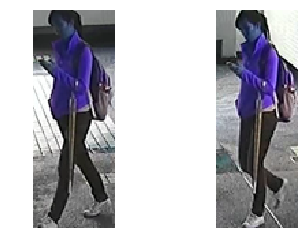

first pic =  0855003.png
second pic =  0812004.png
answer is =  [1 0]


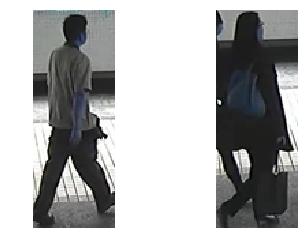

first pic =  0168001.png
second pic =  0168003.png
answer is =  [0 1]


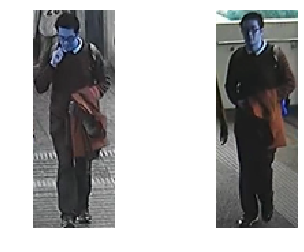

first pic =  0843003.png
second pic =  0843004.png
answer is =  [0 1]


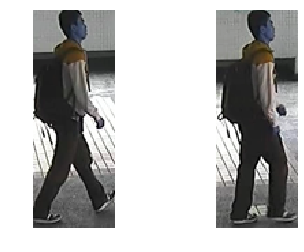

first pic =  0185001.png
second pic =  0185002.png
answer is =  [0 1]


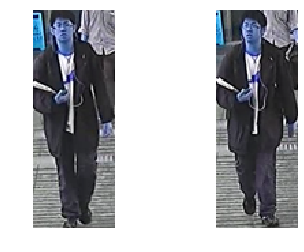

first pic =  0459002.png
second pic =  0459001.png
answer is =  [0 1]


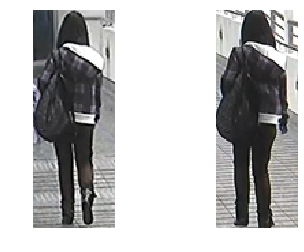

first pic =  0200004.png
second pic =  0200002.png
answer is =  [0 1]


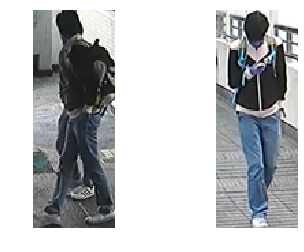

first pic =  0856004.png
second pic =  0441004.png
answer is =  [1 0]


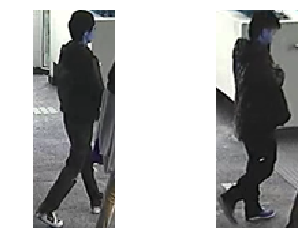

In [4]:
test_dir = '/home/esdl/tensorflow/campus'
test_list, test_data1, test_data2, test_CoN = Image_Data(test_dir)

test_data_index = list(range(len(test_data1)))
random.shuffle(test_data_index)

for i in test_data_index[:10]:
    img1 = cv2.imread(test_dir+'/'+test_list[test_data1[i]],cv2.IMREAD_COLOR)
    img2 = cv2.imread(test_dir+'/'+test_list[test_data2[i]],cv2.IMREAD_COLOR)
    fig , ax = plt.subplots(1, 2)
    ax[0].set_axis_off()
    ax[1].set_axis_off()

    ax[0].imshow(img1)
    ax[1].imshow(img2)
    
    print("first pic = ",test_list[test_data1[i]])
    print("second pic = ",test_list[test_data2[i]])
    print("answer is = ",test_CoN[i])
    plt.show()
    plt.close(fig)

In [41]:
# 버전 3.1임!

tf.reset_default_graph()

data_x_size = 160
data_y_size = 60
stripes = 5

batch_prob = tf.placeholder(tf.bool, name="batch_prob")

X1 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input1") # input image 1
X2 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input2") # input image 2
Y = tf.placeholder(tf.float32, [None, 2]) # output : different = [1 0] / same = [0 1]

#----------------------------------------------------- conv net
with tf.variable_scope("image_filter_1") as scope:
    L1_1 = ConvNet(X1, 3, 32, batch_prob)
    scope.reuse_variables()
    L1_2 = ConvNet(X2, 3, 32, batch_prob)
    L1_1 = tf.nn.max_pool(L1_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L1_2 = tf.nn.max_pool(L1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L1_1,'\n',L1_2)

with tf.variable_scope("image_filter_2") as scope:
    L2_1 = inception2d_v2(L1_1, 32, [10, 70, 4, 4], batch_prob)
    scope.reuse_variables()
    L2_2 = inception2d_v2(L1_2, 32, [10, 70, 4, 4], batch_prob)
    L2_1 = tf.nn.max_pool(L2_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L2_2 = tf.nn.max_pool(L2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L2_1,'\n',L2_2)

with tf.variable_scope("image_filter_3") as scope:
    L3_1 = inception2d_v2(L2_1, 88, [20, 90, 8, 8], batch_prob)
    scope.reuse_variables()
    L3_2 = inception2d_v2(L2_2, 88, [20, 90, 8, 8], batch_prob)
    L3_1 = tf.nn.max_pool(L3_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L3_2 = tf.nn.max_pool(L3_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
print(L3_1,'\n',L3_2)

with tf.variable_scope("image_filter_4") as scope:
    L4_1 = inception2d_v2(L3_1, 126, [30, 100, 12, 12], batch_prob)
    scope.reuse_variables()
    L4_2 = inception2d_v2(L3_2, 126, [30, 100, 12, 12], batch_prob)
    L4_1 = tf.nn.max_pool(L4_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L4_2 = tf.nn.max_pool(L4_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L4_1,'\n',L4_2)

    
with tf.variable_scope("PCB") as scope:
    L5_1 = PCB_v4(L4_1, stripes, batch_prob)
    scope.reuse_variables()
    L5_2 = PCB_v4(L4_2, stripes, batch_prob)
    print(L5_1,'\n',L5_2)
    
#----------------------------------------------------- cross neighborhood difference
with tf.variable_scope("CND") as scope:
    L5_1 = tf.transpose(L5_1,[0,3,1,2])
    L5_2 = tf.transpose(L5_2,[0,3,1,2])
    L5 = CrossND(L5_1,L5_2)
    L5 = tf.transpose(L5,[0,2,3,1])
    L5 = tf.nn.relu(L5)
    print(L5)

#----------------------------------------------------- conv net
with tf.variable_scope("Conv_Net_1") as scope:
    L5 = ConvNet(L5, 154, 154, batch_prob, stride = 3)
    L5 = tf.nn.avg_pool(L5, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L5)
    
#----------------------------------------------------- dense
with tf.variable_scope("Dense") as scope:
    model = FC_layer_v2(L5, 5*2*154, batch_prob)
    model = tf.identity(model, "model")
    print(model)

Tensor("image_filter_1/MaxPool:0", shape=(?, 80, 30, 32), dtype=float32) 
 Tensor("image_filter_1/MaxPool_1:0", shape=(?, 80, 30, 32), dtype=float32)
Tensor("image_filter_2/MaxPool:0", shape=(?, 40, 15, 88), dtype=float32) 
 Tensor("image_filter_2/MaxPool_1:0", shape=(?, 40, 15, 88), dtype=float32)
Tensor("image_filter_3/MaxPool:0", shape=(?, 20, 8, 126), dtype=float32) 
 Tensor("image_filter_3/MaxPool_1:0", shape=(?, 20, 8, 126), dtype=float32)
Tensor("image_filter_4/MaxPool:0", shape=(?, 10, 4, 154), dtype=float32) 
 Tensor("image_filter_4/MaxPool_1:0", shape=(?, 10, 4, 154), dtype=float32)
Tensor("PCB/Relu:0", shape=(?, 10, 4, 154), dtype=float32) 
 Tensor("PCB/Relu_1:0", shape=(?, 10, 4, 154), dtype=float32)
Tensor("CND/Relu:0", shape=(?, 30, 12, 154), dtype=float32)
Tensor("Conv_Net_1/AvgPool:0", shape=(?, 5, 2, 154), dtype=float32)
Tensor("Dense/model:0", shape=(?, 2), dtype=float32)


In [37]:
# 버전 3.1임!

tf.reset_default_graph()

data_x_size = 160
data_y_size = 60
stripes = 5

batch_prob = tf.placeholder(tf.bool, name="batch_prob")

X1 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input1") # input image 1
X2 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input2") # input image 2
Y = tf.placeholder(tf.float32, [None, 2]) # output : different = [1 0] / same = [0 1]

#----------------------------------------------------- conv net
with tf.variable_scope("image_filter_1") as scope:
    L1_1 = ConvNet(X1, 3, 32, batch_prob)
    scope.reuse_variables()
    L1_2 = ConvNet(X2, 3, 32, batch_prob)
    L1_1 = tf.nn.max_pool(L1_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L1_2 = tf.nn.max_pool(L1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L1_1,'\n',L1_2)

with tf.variable_scope("image_filter_2") as scope:
    L2_1 = inception2d_v2(L1_1, 32, [10, 70, 4, 4], batch_prob)
    scope.reuse_variables()
    L2_2 = inception2d_v2(L1_2, 32, [10, 70, 4, 4], batch_prob)
    L2_1 = tf.nn.max_pool(L2_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L2_2 = tf.nn.max_pool(L2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L2_1,'\n',L2_2)

with tf.variable_scope("image_filter_3") as scope:
    L3_1 = inception2d_v2(L2_1, 88, [20, 90, 8, 8], batch_prob)
    scope.reuse_variables()
    L3_2 = inception2d_v2(L2_2, 88, [20, 90, 8, 8], batch_prob)
    L3_1 = tf.nn.max_pool(L3_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L3_2 = tf.nn.max_pool(L3_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
print(L3_1,'\n',L3_2)

with tf.variable_scope("image_filter_4") as scope:
    L4_1 = inception2d_v2(L3_1, 126, [30, 100, 12, 12], batch_prob)
    scope.reuse_variables()
    L4_2 = inception2d_v2(L3_2, 126, [30, 100, 12, 12], batch_prob)
    L4_1 = tf.nn.max_pool(L4_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L4_2 = tf.nn.max_pool(L4_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L4_1,'\n',L4_2)

    
with tf.variable_scope("PCB") as scope:
    L5_1 = PCB_v4(L4_1, stripes, batch_prob)
    scope.reuse_variables()
    L5_2 = PCB_v4(L4_2, stripes, batch_prob)
    print(L5_1,'\n',L5_2)
    
#----------------------------------------------------- cross neighborhood difference
with tf.variable_scope("CND") as scope:
    L5_1 = tf.transpose(L5_1,[0,3,1,2])
    L5_2 = tf.transpose(L5_2,[0,3,1,2])
    L5 = CrossND(L5_1,L5_2)
    L5 = tf.transpose(L5,[0,2,3,1])
    L5 = tf.nn.relu(L5)
    print(L5)

#----------------------------------------------------- conv net
with tf.variable_scope("Conv_Net_1") as scope:
    L5 = ConvNet(L5, 154, 154, batch_prob, stride = 3)
    L5 = tf.nn.avg_pool(L5, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L5)
    
#----------------------------------------------------- dense
with tf.variable_scope("Dense_1") as scope:
    Part = Seperator_v3(L5,stripes)
    print(Part)
    model = FC_layer_v3(Part[:,:154],154,batch_prob,1)
    for i in range(1, stripes):
        scope.reuse_variables()
        chunk = FC_layer_v3(Part[:,i*154:(i+1)*154], 154, batch_prob,1)
        model = tf.concat([model, chunk], axis = 1)
    print(model)
    
with tf.variable_scope("Dense_2") as scope: 
    model = FC_layer_v3(model, 5, batch_prob)
    model = tf.identity(model, "model")
    print(model)

Tensor("image_filter_1/MaxPool:0", shape=(?, 80, 30, 32), dtype=float32) 
 Tensor("image_filter_1/MaxPool_1:0", shape=(?, 80, 30, 32), dtype=float32)
Tensor("image_filter_2/MaxPool:0", shape=(?, 40, 15, 88), dtype=float32) 
 Tensor("image_filter_2/MaxPool_1:0", shape=(?, 40, 15, 88), dtype=float32)
Tensor("image_filter_3/MaxPool:0", shape=(?, 20, 8, 126), dtype=float32) 
 Tensor("image_filter_3/MaxPool_1:0", shape=(?, 20, 8, 126), dtype=float32)
Tensor("image_filter_4/MaxPool:0", shape=(?, 10, 4, 154), dtype=float32) 
 Tensor("image_filter_4/MaxPool_1:0", shape=(?, 10, 4, 154), dtype=float32)
Tensor("PCB/Relu:0", shape=(?, 10, 4, 154), dtype=float32) 
 Tensor("PCB/Relu_1:0", shape=(?, 10, 4, 154), dtype=float32)
Tensor("CND/Relu:0", shape=(?, 30, 12, 154), dtype=float32)
Tensor("Conv_Net_1/AvgPool:0", shape=(?, 5, 2, 154), dtype=float32)
Tensor("Dense_1/concat_3:0", shape=(?, 770), dtype=float32)
Tensor("Dense_1/concat_7:0", shape=(?, 5), dtype=float32)
Tensor("Dense_2/model:0", shape=

In [7]:
# 버전 3임!

tf.reset_default_graph()

data_x_size = 160
data_y_size = 60
stripes = 5

batch_prob = tf.placeholder(tf.bool, name="batch_prob")

X1 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input1") # input image 1
X2 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input2") # input image 2
Y = tf.placeholder(tf.float32, [None, 2]) # output : different = [1 0] / same = [0 1]

#----------------------------------------------------- conv net
with tf.variable_scope("image_filter_1") as scope:
    L1_1 = ConvNet(X1, 3, 32, batch_prob)
    scope.reuse_variables()
    L1_2 = ConvNet(X2, 3, 32, batch_prob)
    L1_1 = tf.nn.max_pool(L1_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L1_2 = tf.nn.max_pool(L1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L1_1,'\n',L1_2)

with tf.variable_scope("image_filter_2") as scope:
    L2_1 = inception2d_v2(L1_1, 32, [10, 70, 4, 4], batch_prob)
    scope.reuse_variables()
    L2_2 = inception2d_v2(L1_2, 32, [10, 70, 4, 4], batch_prob)
    L2_1 = tf.nn.max_pool(L2_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L2_2 = tf.nn.max_pool(L2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L2_1,'\n',L2_2)

with tf.variable_scope("image_filter_3") as scope:
    L3_1 = inception2d_v2(L2_1, 88, [20, 90, 8, 8], batch_prob)
    scope.reuse_variables()
    L3_2 = inception2d_v2(L2_2, 88, [20, 90, 8, 8], batch_prob)
    L3_1 = tf.nn.max_pool(L3_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L3_2 = tf.nn.max_pool(L3_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
print(L3_1,'\n',L3_2)

with tf.variable_scope("image_filter_4") as scope:
    L4_1 = inception2d_v2(L3_1, 126, [30, 100, 12, 12], batch_prob)
    scope.reuse_variables()
    L4_2 = inception2d_v2(L3_2, 126, [30, 100, 12, 12], batch_prob)
    L4_1 = tf.nn.max_pool(L4_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L4_2 = tf.nn.max_pool(L4_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L4_1,'\n',L4_2)

    
with tf.variable_scope("PCB") as scope:
    L5_1 = PCB_v2(L4_1, stripes)
    scope.reuse_variables()
    L5_2 = PCB_v2(L4_2, stripes)
    print(L5_1,'\n',L5_2)
    
#----------------------------------------------------- cross neighborhood difference
with tf.variable_scope("CND") as scope:
    L5_1 = tf.transpose(L5_1,[0,3,1,2])
    L5_2 = tf.transpose(L5_2,[0,3,1,2])
    L5 = CrossND(L5_1,L5_2)
    L5 = tf.transpose(L5,[0,2,3,1])
    L5 = tf.nn.relu(L5)
    print(L5)

#----------------------------------------------------- conv net
with tf.variable_scope("Conv_Net_1") as scope:
    L5 = ConvNet(L5, 770, 770, batch_prob, stride = 3)
    L5 = tf.nn.avg_pool(L5, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L5)
    
#----------------------------------------------------- dense
with tf.variable_scope("Dense") as scope:
    Part = Seperator_v2(L5,stripes)
    print(Part)
    model = FC_layer_v3(Part, 770, batch_prob)
    model = tf.identity(model, "model")
    print(model)

Tensor("image_filter_1/MaxPool:0", shape=(?, 80, 30, 32), dtype=float32) 
 Tensor("image_filter_1/MaxPool_1:0", shape=(?, 80, 30, 32), dtype=float32)
Tensor("image_filter_2/MaxPool:0", shape=(?, 40, 15, 88), dtype=float32) 
 Tensor("image_filter_2/MaxPool_1:0", shape=(?, 40, 15, 88), dtype=float32)
Tensor("image_filter_3/MaxPool:0", shape=(?, 20, 8, 126), dtype=float32) 
 Tensor("image_filter_3/MaxPool_1:0", shape=(?, 20, 8, 126), dtype=float32)
Tensor("image_filter_4/MaxPool:0", shape=(?, 10, 4, 154), dtype=float32) 
 Tensor("image_filter_4/MaxPool_1:0", shape=(?, 10, 4, 154), dtype=float32)
Tensor("PCB/Relu:0", shape=(?, 10, 4, 770), dtype=float32) 
 Tensor("PCB/Relu_1:0", shape=(?, 10, 4, 770), dtype=float32)
Tensor("CND/Relu:0", shape=(?, 30, 12, 770), dtype=float32)
Tensor("Conv_Net_1/AvgPool:0", shape=(?, 5, 2, 770), dtype=float32)
Tensor("Dense/concat_3:0", shape=(?, 770), dtype=float32)
Tensor("Dense/model:0", shape=(?, 2), dtype=float32)


In [ ]:
tf.reset_default_graph()

data_x_size = 160
data_y_size = 60
stripes = 5
model = []

batch_prob = tf.placeholder(tf.bool, name="batch_prob")

X1 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input1") # input image 1
X2 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input2") # input image 2
Y = tf.placeholder(tf.float32, [None, 2]) # output : different = [1 0] / same = [0 1]

#----------------------------------------------------- conv net
with tf.variable_scope("image_filter_1") as scope:
    L1_1 = ConvNet(X1, 3, 32, batch_prob)
    scope.reuse_variables()
    L1_2 = ConvNet(X2, 3, 32, batch_prob)
    L1_1 = tf.nn.max_pool(L1_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L1_2 = tf.nn.max_pool(L1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L1_1,'\n',L1_2)

with tf.variable_scope("image_filter_2") as scope:
    L2_1 = inception2d_v2(L1_1, 32, [10, 70, 4, 4], batch_prob)
    scope.reuse_variables()
    L2_2 = inception2d_v2(L1_2, 32, [10, 70, 4, 4], batch_prob)
    L2_1 = tf.nn.max_pool(L2_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L2_2 = tf.nn.max_pool(L2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L2_1,'\n',L2_2)

with tf.variable_scope("image_filter_3") as scope:
    L3_1 = inception2d_v2(L2_1, 88, [20, 90, 8, 8], batch_prob)
    scope.reuse_variables()
    L3_2 = inception2d_v2(L2_2, 88, [20, 90, 8, 8], batch_prob)
    L3_1 = tf.nn.max_pool(L3_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L3_2 = tf.nn.max_pool(L3_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L3_1,'\n',L3_2)

with tf.variable_scope("PCB_Part") as scope:
    L4_1 = PCB_v2(L3_1, stripes, False)
    scope.reuse_variables()
    L4_2 = PCB_v2(L3_2, stripes, False)
    print(L4_1,'\n',L4_2)

#----------------------------------------------------- cross neighborhood difference
L4_1 = tf.transpose(L4_1,[0,3,1,2])
L4_2 = tf.transpose(L4_2,[0,3,1,2])
L4 = CrossND(L4_1,L4_2)
L4 = tf.transpose(L4,[0,2,3,1])
L4 = tf.nn.relu(L4)
print(L4)

#----------------------------------------------------- conv net
with tf.variable_scope("Conv_Net_1") as scope:
    s = int(int(L4.shape[3])/stripes)
    L5 = ConvNet(L4[:,:,:,:s], 126, 100, batch_prob, stride = 3)
    for i in range(1, stripes):
        scope.reuse_variables()
        L5_chunk = ConvNet(L4[:,:,:,i*s:(i+1)*s], 126, 100, batch_prob, stride = 3)
        L5 = tf.concat([L5,L5_chunk], axis=3)
    L5 = tf.nn.max_pool(L5, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L5)

#----------------------------------------------------- dense
Part = Seperator(L5,stripes)
for i in range(stripes):
    with tf.variable_scope("Part_"+str(i)) as scope:
        model.append(FC_layer_v2(Part[i], 100, batch_prob))
model = tf.identity(model, "model")
print(model)

In [ ]:
tf.reset_default_graph()

data_x_size = 160
data_y_size = 60
stripes = 5
model = []

batch_prob = tf.placeholder(tf.bool, name="batch_prob")

X1 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input1") # input image 1
X2 = tf.placeholder(tf.float32, [None, data_x_size, data_y_size, 3], name="input2") # input image 2
Y = tf.placeholder(tf.float32, [None, 2]) # output : different = [1 0] / same = [0 1]

#----------------------------------------------------- conv net
with tf.variable_scope("image_filter_1") as scope:
    L1_1 = ConvNet(X1, 3, 32, batch_prob)
    scope.reuse_variables()
    L1_2 = ConvNet(X2, 3, 32, batch_prob)
    L1_1 = tf.nn.max_pool(L1_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L1_2 = tf.nn.max_pool(L1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L1_1,'\n',L1_2)

with tf.variable_scope("image_filter_2") as scope:
    L2_1 = inception2d_v2(L1_1, 32, [10, 70, 4, 4], batch_prob)
    scope.reuse_variables()
    L2_2 = inception2d_v2(L1_2, 32, [10, 70, 4, 4], batch_prob)
    L2_1 = tf.nn.max_pool(L2_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L2_2 = tf.nn.max_pool(L2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L2_1,'\n',L2_2)

with tf.variable_scope("image_filter_3") as scope:
    L3_1 = inception2d_v2(L2_1, 88, [20, 90, 8, 8], batch_prob)
    scope.reuse_variables()
    L3_2 = inception2d_v2(L2_2, 88, [20, 90, 8, 8], batch_prob)
    L3_1 = tf.nn.max_pool(L3_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    L3_2 = tf.nn.max_pool(L3_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L3_1,'\n',L3_2)

#----------------------------------------------------- cross neighborhood difference
with tf.variable_scope("CND") as scope:
    L4_1 = tf.transpose(L3_1,[0,3,1,2])
    L4_2 = tf.transpose(L3_2,[0,3,1,2])
    L4 = CrossND(L4_1,L4_2)
    L4 = tf.transpose(L4,[0,2,3,1])
    L4 = tf.nn.relu(L4)
    print(L4)

#----------------------------------------------------- conv net
with tf.variable_scope("Conv_Net_1") as scope:
    L5 = ConvNet(L4, 126, 252, batch_prob, stride = 3)
    L5 = tf.nn.max_pool(L5, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L5)

#----------------------------------------------------- dense
with tf.variable_scope("PCB_Part") as scope:
    L6 = PCB_v3(L5, stripes, False)
    print(L6)

Part = Seperator(L6,stripes)
for i in range(stripes):
    with tf.variable_scope("Part_"+str(i)) as scope:
        model.append(FC_layer_v2(Part[i], 252, batch_prob))
model = tf.identity(model, "model")
print(model)

In [42]:
batch_size=100
total_batch=int(len(train_data1) / batch_size)
print("전체 데이터 크기는",len(train_data1),"배치 크기는",batch_size,"전체 배치는",total_batch)
#cost = []

#for i in range(stripes):
    #cost.append(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=model[i])))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=model))

#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.00006
#learning_rate = starter_learning_rate
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                           total_batch, 0.99, staircase=True)
#optimizer = tf.train.AdamOptimizer(0.00006).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.00006).minimize(cost)
#optimizer = tf.train.RMSPropOptimizer(0.00006).minimize(cost)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    #optimizer = tf.train.RMSPropOptimizer(0.00006).minimize(sum(cost))
    optimizer = tf.train.RMSPropOptimizer(0.00006).minimize(cost)


# tf.train.Saver를 이용해서 모델과 파라미터를 저장합니다.
SAVER_DIR = "Re_Id_v3_model/Ver3.1"
saver = tf.train.Saver()
checkpoint_path = os.path.join(SAVER_DIR, "model")
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)
    
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for epoch in range(100):
    total_cost=0
    index_num=0
    for i in range(total_batch):
        
        input_data1 = np.empty((batch_size, data_x_size, data_y_size, 3))
        input_data2 = np.empty((batch_size, data_x_size, data_y_size, 3))
        batch_i=0
        for index_num in data_index[i*batch_size:(i+1)*batch_size]:
            input_data1[batch_i,:,:,:] = cv2.imread(train_dir+'/'+train_list[train_data1[index_num]],cv2.IMREAD_COLOR)
            input_data2[batch_i,:,:,:] = cv2.imread(train_dir+'/'+train_list[train_data2[index_num]],cv2.IMREAD_COLOR)
            batch_i = batch_i+1
        batch_ys = train_CoN[i*batch_size : (i+1)*batch_size]
        _, cost_val=sess.run([optimizer, cost], feed_dict={X1:input_data1, X2:input_data2, Y:batch_ys, batch_prob: True})
        #total_cost += sum(cost_val)
        total_cost += cost_val
    saver.save(sess, checkpoint_path, global_step=epoch+1)
    print('Epoch:', '%04d' % (epoch + 1), 'Avg.cost=', '{:.3f}'.format(total_cost / total_batch))
    
    if (epoch+1)%5 == 0:
        test_size=100
        output = tf.nn.softmax(model)
        #output = tf.transpose(output,[1, 0, 2])
        #output=tf.reduce_mean(output, axis=1)
        is_correct=tf.equal(tf.argmax(output,1),tf.argmax(Y,1))
        accuracy=tf.reduce_mean(tf.cast(is_correct, tf.float32))
        test_img1 = np.empty((test_size, data_x_size, data_y_size,3))
        test_img2 = np.empty((test_size, data_x_size, data_y_size,3))
        for i in range(test_size):
            test_img1[i,:,:,:] = cv2.imread(test_dir+'/'+test_list[test_data1[test_data_index[i]]],cv2.IMREAD_COLOR)
            test_img2[i,:,:,:] = cv2.imread(test_dir+'/'+test_list[test_data2[test_data_index[i]]],cv2.IMREAD_COLOR)

        ac = sess.run(accuracy, feed_dict={X1:test_img1,
                                            X2:test_img2,
                                            Y:test_CoN[test_data_index[:test_size]],
                                            batch_prob: False})
        print('정확도:', ac)


    
print('Optimized!')


전체 데이터 크기는 88020 배치 크기는 100 전체 배치는 880
Epoch: 0001 Avg.cost= 0.644
Epoch: 0002 Avg.cost= 0.547
Epoch: 0003 Avg.cost= 0.481
Epoch: 0004 Avg.cost= 0.426
Epoch: 0005 Avg.cost= 0.379
정확도: 0.77
Epoch: 0006 Avg.cost= 0.340
Epoch: 0007 Avg.cost= 0.304
Epoch: 0008 Avg.cost= 0.271
Epoch: 0009 Avg.cost= 0.241
Epoch: 0010 Avg.cost= 0.213
정확도: 0.74
Epoch: 0011 Avg.cost= 0.188
Epoch: 0012 Avg.cost= 0.166
Epoch: 0013 Avg.cost= 0.146
Epoch: 0014 Avg.cost= 0.129
Epoch: 0015 Avg.cost= 0.114
정확도: 0.76
Epoch: 0016 Avg.cost= 0.101
Epoch: 0017 Avg.cost= 0.090
Epoch: 0018 Avg.cost= 0.080


KeyboardInterrupt: 

In [ ]:
sess.close()
tf.reset_default_graph()

In [ ]:
SAVER_DIR = "Re_Id_v3_model"
checkpoint_path = os.path.join(SAVER_DIR, "model")
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)

sess = tf.InteractiveSession()

init = tf.global_variables_initializer()
sess.run(init)

new_saver = tf.train.import_meta_graph(ckpt.model_checkpoint_path+".meta")
new_saver.restore(sess, ckpt.model_checkpoint_path)

tf.get_default_graph()

X1 = sess.graph.get_tensor_by_name("input1:0")
X2 = sess.graph.get_tensor_by_name("input2:0")
batch_prob = sess.graph.get_tensor_by_name("batch_prob:0")
model = sess.graph.get_tensor_by_name("model:0")
#print(sess.graph.get_operation_by_name('Conv_Net_1/W').outputs[0])
#print(sess.run('Conv_Net_1/W:0'))

In [ ]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='New_PCB_Part')

In [ ]:
stripes = 5
new_L3_1 = sess.graph.get_tensor_by_name("image_filter_3/MaxPool:0")
new_L3_2 = sess.graph.get_tensor_by_name("image_filter_3/MaxPool_1:0")
Y = tf.placeholder(tf.float32, [None, 2])
new_model = []

with tf.variable_scope("New_PCB_Part") as scope:
    L4_1 = PCB_v3(new_L3_1, stripes, batch_prob)#, False)
    scope.reuse_variables()
    L4_2 = PCB_v3(new_L3_2, stripes, batch_prob)#, False)
    print(L4_1,'\n',L4_2)

#----------------------------------------------------- cross neighborhood difference
L4_1 = tf.transpose(L4_1,[0,3,1,2])
L4_2 = tf.transpose(L4_2,[0,3,1,2])
L4 = CrossND(L4_1,L4_2)
L4 = tf.transpose(L4,[0,2,3,1])
L4 = tf.nn.relu(L4)
print(L4)

#----------------------------------------------------- conv net
with tf.variable_scope("New_Conv_Net_1") as scope:#, reuse = True) as scope:
    s = int(int(L4.shape[3])/stripes)
    #scope.reuse_variables()
    L5 = ConvNet(L4[:,:,:,:s], 126, 100, batch_prob, stride = 3)
    for i in range(1, stripes):
        scope.reuse_variables()
        L5_chunk = ConvNet(L4[:,:,:,i*s:(i+1)*s], 126, 100, batch_prob, stride = 3)
        L5 = tf.concat([L5,L5_chunk], axis=3)
    L5 = tf.nn.max_pool(L5, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    print(L5)
#----------------------------------------------------- dense
Part = Seperator(L5,stripes)
for i in range(stripes):
    with tf.variable_scope("New_Part_"+str(i)) as scope:#, reuse = True) as scope:
        #scope.reuse_variables()
        new_model.append(FC_layer_v2(Part[i], 100, batch_prob))
new_model = tf.identity(new_model, "new_model")
print(new_model)

In [ ]:
batch_size=25
total_batch=int(len(train_data1) / batch_size)
print("전체 데이터 크기는",len(train_data1),"배치 크기는",batch_size,"전체 배치는",total_batch)
cost = []

for i in range(stripes):
    cost.append(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=new_model[i])))

#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.00006
#learning_rate = starter_learning_rate
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                           total_batch, 0.99, staircase=True)
#optimizer = tf.train.AdamOptimizer(0.00006).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.00006).minimize(cost)
#optimizer = tf.train.RMSPropOptimizer(0.00006).minimize(cost)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.RMSPropOptimizer(0.00006).minimize(sum(cost),
                                                    var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='New_PCB_Part|New_Conv_Net_1|New_Part_[0-4]'))


# tf.train.Saver를 이용해서 모델과 파라미터를 저장합니다.
SAVER_DIR = "Re_Id_v3_model/Ver2."
#saver = tf.train.Saver()
checkpoint_path = os.path.join(SAVER_DIR, "model")
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)
    
#init = tf.global_variables_initializer()
#sess = tf.Session()
#sess.run(init)
#new_init = tf.initializer.variables(['New_PCB_Part/PCB_W'])
initialize_uninitialized(sess)

for epoch in range(500):
    total_cost=0
    index_num=0
    for i in range(total_batch):
        
        input_data1 = np.empty((batch_size, data_x_size, data_y_size, 3))
        input_data2 = np.empty((batch_size, data_x_size, data_y_size, 3))
        batch_i=0
        for index_num in data_index[i*batch_size:(i+1)*batch_size]:
            input_data1[batch_i,:,:,:] = cv2.imread(train_dir+'/'+train_list[train_data1[index_num]],cv2.IMREAD_COLOR)
            input_data2[batch_i,:,:,:] = cv2.imread(train_dir+'/'+train_list[train_data2[index_num]],cv2.IMREAD_COLOR)
            batch_i = batch_i+1
        batch_ys = train_CoN[i*batch_size : (i+1)*batch_size]
        _, cost_val=sess.run([optimizer, cost], feed_dict={X1:input_data1, X2:input_data2, Y:batch_ys, batch_prob: True})
        total_cost += sum(cost_val)
    #saver.save(sess, checkpoint_path, global_step=epoch+1)
    print('Epoch:', '%04d' % (epoch + 1), 'Avg.cost=', '{:.3f}'.format(total_cost / total_batch))
    
    if (epoch+1)%5 == 0:
        test_size=100
        output = tf.nn.softmax(new_model)
        output = tf.transpose(output,[1, 0, 2])
        output=tf.reduce_mean(output, axis=1)
        is_correct=tf.equal(tf.argmax(output,1),tf.argmax(Y,1))
        accuracy=tf.reduce_mean(tf.cast(is_correct, tf.float32))
        test_img1 = np.empty((test_size, data_x_size, data_y_size,3))
        test_img2 = np.empty((test_size, data_x_size, data_y_size,3))
        for i in range(test_size):
            test_img1[i,:,:,:] = cv2.imread(test_dir+'/'+test_list[test_data1[test_data_index[i]]],cv2.IMREAD_COLOR)
            test_img2[i,:,:,:] = cv2.imread(test_dir+'/'+test_list[test_data2[test_data_index[i]]],cv2.IMREAD_COLOR)

        ac = sess.run(accuracy, feed_dict={X1:test_img1,
                                            X2:test_img2,
                                            Y:test_CoN[test_data_index[:test_size]],
                                            batch_prob: False})
        print('정확도:', ac)


    
print('Optimized!')


In [15]:
# temp_dir = '/home/esdl/tensorflow/campus'
# temp_dir = '/home/esdl/tensorflow/cuhk03_release/images/detected'
temp_dir = '/home/esdl/tensorflow/Market-1501-v15.09.15/bounding_box_train'
pick_person = 100

temp_list,temp1,temp2,temp_CoN = ALL_Image_Data(temp_dir,pick_person)
temp_index = list(range(len(temp1)))

이미지 파일 총 갯수 :  12936
뽑을 사람 :  100
100 명 만큼의 사람의 사진은 1747 장 입니다.


PID : 1
[1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0]


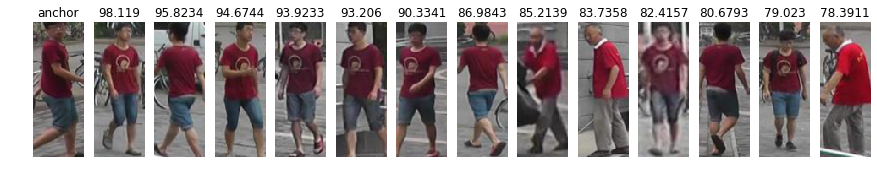

PID : 2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


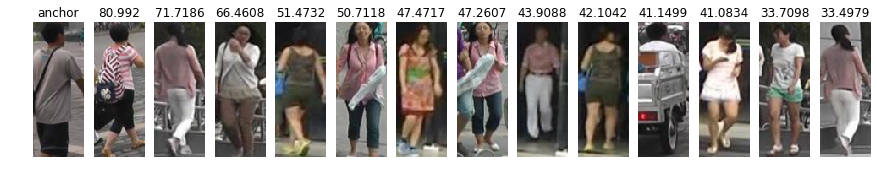

PID : 3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


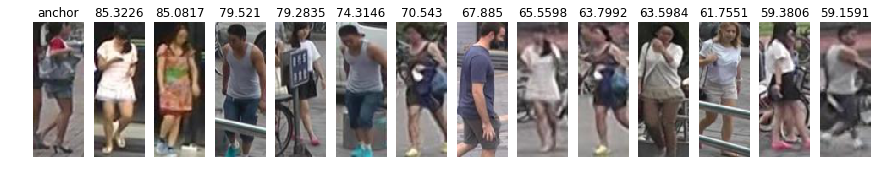

PID : 4
[1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


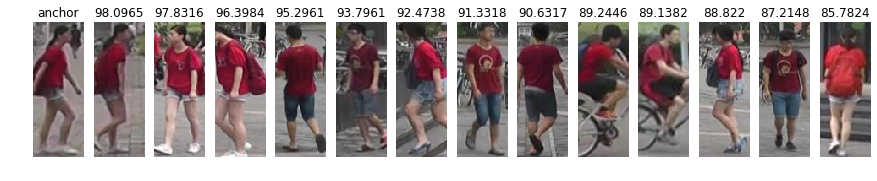

PID : 5
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


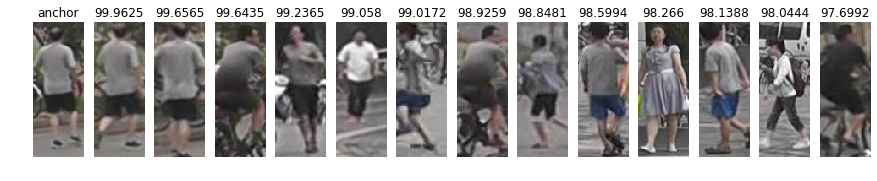

PID : 6
[1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


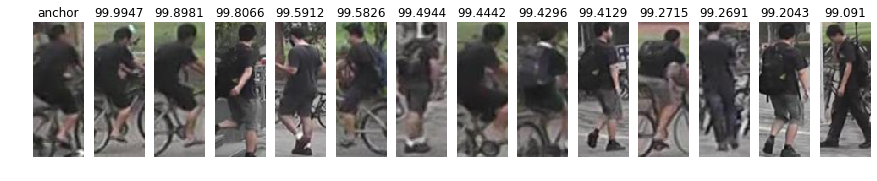

In [ ]:
display = True

data_x_size = 160
data_y_size = 60

start_point = 0

batch_limit = 500
batch = [0, 0, 0] # start, end, length
total_batch = 0
change = temp1[0]
order = 1

rank = []
rank_index = []
total_result = []
rank_accuracy = np.empty((pick_person,20),dtype=int)

for i in range(len(temp1)):
    
    if change == temp1[i] and i+1 != len(temp1) and (i-batch[0]) < batch_limit:
        continue
        
    change = temp1[i]
    batch[1] = i
    batch[2] = batch[1]-batch[0]
    
    if i+1 == len(temp1):
        batch[1] += 1
        batch[2] += 1
        
    img1 = np.empty((batch[2], data_x_size, data_y_size, 3),dtype='uint8')
    img2 = np.empty((batch[2], data_x_size, data_y_size, 3),dtype='uint8')
    result = np.empty(batch[2],dtype=int)
       
    for j in range(0,batch[2]):
        img1[j,:,:,:] = cv2.resize(cv2.imread(temp_dir+'/'+temp_list[temp1[batch[0]+j]],cv2.IMREAD_COLOR),(data_y_size,data_x_size))
        img2[j,:,:,:] = cv2.resize(cv2.imread(temp_dir+'/'+temp_list[temp2[batch[0]+j]],cv2.IMREAD_COLOR),(data_y_size,data_x_size))
        result[j] = temp_CoN[batch[0]+j,1]
    batch[0] = i
    
    answer = tf.nn.softmax(model)
    #answer = tf.transpose(answer,[1, 0, 2])
    #answer= tf.reduce_mean(answer, axis=1)
    answer = sess.run(answer,feed_dict={X1:img1, X2:img2, batch_prob : False})
    rank.extend(answer[:,1])
    total_result.extend(result)
    
    if temp1[i] == temp1[i-1] and i+1 != len(temp1): continue
    
    rank = np.array(rank)
    total_result = np.array(total_result)
    rank_index = np.argsort(rank)
    ranking = np.round((rank[rank_index[::-1]]*100),4)
    
    print("PID :",order)
    
    total_result = total_result[rank_index[::-1]][:20]
    rank_accuracy[order-1,:] = total_result
    print(total_result)
    
    order += 1
    
    if display:
        fig , ax = plt.subplots(1, 14, figsize=(15,15))
        ax[0].set_axis_off()
        ax[0].imshow(cv2.cvtColor(img1[0], cv2.COLOR_BGR2RGB))
        ax[0].set_title("anchor")
        for j in range(1,14):
            ax[j].set_axis_off()
            compare_image = cv2.resize(cv2.imread(temp_dir+'/'+temp_list[temp2[start_point+rank_index[-j]]],cv2.IMREAD_COLOR),
                                                                                       (data_y_size,data_x_size))
            #ax[j].imshow(cv2.cvtColor(img2[rank_index[-j]], cv2.COLOR_BGR2RGB))
            ax[j].imshow(cv2.cvtColor(compare_image, cv2.COLOR_BGR2RGB))
            ax[j].set_title(ranking[j])
        plt.show()
        plt.close(fig)
    
    rank = []
    rank_index = []
    total_result = []
    start_point = i

print("rank = 1 accuarcy is :",rank_accuracy[:,0].sum(axis=0))
print("rank = 5 accuarcy is :",(rank_accuracy[:,:5].sum(axis=1)>0).astype(int).sum(axis=0))
print("rank = 10 accuarcy is :",(rank_accuracy[:,:10].sum(axis=1)>0).astype(int).sum(axis=0))
print("rank = 20 accuarcy is :",(rank_accuracy[:,:20].sum(axis=1)>0).astype(int).sum(axis=0))

In [ ]:
display = True

data_x_size = 160
data_y_size = 60

start_point = 0

batch_limit = 500
batch = [0, 0, 0] # start, end, length
total_batch = 0
change = temp1[0]
order = 1

rank = []
rank_index = []
total_result = []
rank_accuracy = np.empty((pick_person,20),dtype=int)

for i in range(len(temp1)):
    
    if change == temp1[i] and i+1 != len(temp1) and (i-batch[0]) < batch_limit:
        continue
        
    change = temp1[i]
    batch[1] = i
    batch[2] = batch[1]-batch[0]
    
    if i+1 == len(temp1):
        batch[1] += 1
        batch[2] += 1
        
    img1 = np.empty((batch[2], data_x_size, data_y_size, 3),dtype='uint8')
    img2 = np.empty((batch[2], data_x_size, data_y_size, 3),dtype='uint8')
    result = np.empty(batch[2],dtype=int)
       
    for j in range(0,batch[2]):
        img1[j,:,:,:] = cv2.resize(cv2.imread(temp_dir+'/'+temp_list[temp1[batch[0]+j]],cv2.IMREAD_COLOR),(data_y_size,data_x_size))
        img2[j,:,:,:] = cv2.resize(cv2.imread(temp_dir+'/'+temp_list[temp2[batch[0]+j]],cv2.IMREAD_COLOR),(data_y_size,data_x_size))
        result[j] = temp_CoN[batch[0]+j,1]
    batch[0] = i
    
    answer = tf.nn.softmax(model)
    answer = tf.transpose(answer,[1, 0, 2])
    test_check = answer
    answer= tf.reduce_mean(answer, axis=1)
    answer,test_check = sess.run([answer,test_check],feed_dict={X1:img1, X2:img2, batch_prob: False})
    rank.extend(answer[:,1])
    total_result.extend(result)
    
    if temp1[i] == temp1[i-1] and i+1 != len(temp1): continue
    
    rank = np.array(rank)
    total_result = np.array(total_result)
    rank_index = np.argsort(rank)
    ranking = np.round((rank[rank_index[::-1]]*100),4)
    
    print("PID :",order)
    
    total_result = total_result[rank_index[::-1]][:20]
    rank_accuracy[order-1,:] = total_result
    print(total_result)
    
    order += 1
    
    if display:
        fig , ax = plt.subplots(1, 14, figsize=(15,15))
        ax[0].set_axis_off()
        ax[0].imshow(cv2.cvtColor(img1[0], cv2.COLOR_BGR2RGB))
        ax[0].set_title("anchor")
        for j in range(1,14):
            ax[j].set_axis_off()
            compare_image = cv2.resize(cv2.imread(temp_dir+'/'+temp_list[temp2[start_point+rank_index[-j]]],cv2.IMREAD_COLOR),
                                                                                       (data_y_size,data_x_size))
            #ax[j].imshow(cv2.cvtColor(img2[rank_index[-j]], cv2.COLOR_BGR2RGB))
            ax[j].imshow(cv2.cvtColor(compare_image, cv2.COLOR_BGR2RGB))
            ax[j].set_title(ranking[j])
        plt.show()
        plt.close(fig)

    #print((test_check[rank_index[::-1][:5]]*100).astype(int))    
    
    rank = []
    rank_index = []
    total_result = []
    start_point = i

print("rank = 1 accuarcy is :",rank_accuracy[:,0].sum(axis=0))
print("rank = 5 accuarcy is :",(rank_accuracy[:,:5].sum(axis=1)>0).astype(int).sum(axis=0))
print("rank = 10 accuarcy is :",(rank_accuracy[:,:10].sum(axis=1)>0).astype(int).sum(axis=0))
print("rank = 20 accuarcy is :",(rank_accuracy[:,:20].sum(axis=1)>0).astype(int).sum(axis=0))